In [93]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


In [94]:
# Step 1: Load Data
public_data = sc.read_h5ad("data/cell_atlas_of_the_human_lung_in_health_and_disease_full.h5ad")
hospital_data = sc.read_h5ad("data/raw-count-full-genes-with-cell-type-annotation.h5ad")

In [95]:
print("Public Data:")
print(public_data)
print("Hospital Data:")
print(hospital_data)

Public Data:
AnnData object with n_obs × n_vars = 2282447 × 56239
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_un

In [114]:
disease_counts_pub = public_data.obs['disease'].value_counts()
print(disease_counts_pub)

for level in ['level_1', 'level_2', 'level_3', 'level_4', 'level_5']:
        column_name = f'ann_level_{level.split("_")[1]}'
        print(f"\n{column_name} Distribution:")
        print(public_data.obs[column_name].value_counts())

disease
normal                                   1305099
COVID-19                                  341761
pulmonary fibrosis                        268932
interstitial lung disease                  68456
chronic obstructive pulmonary disease      67943
lung adenocarcinoma                        62807
pneumonia                                  31923
chronic rhinitis                           29137
lung large cell carcinoma                  21167
squamous cell lung carcinoma               20631
cystic fibrosis                            17590
lymphangioleiomyomatosis                   12374
pleomorphic carcinoma                      10765
hypersensitivity pneumonitis               10379
non-specific interstitial pneumonia         8597
pulmonary sarcoidosis                       4886
Name: count, dtype: int64

ann_level_1 Distribution:
ann_level_1
Immune         1222972
Epithelial      705307
Stroma          181028
Endothelial     156585
Unknown          16555
Name: count, dtype: int64

a

In [96]:
def extract_cell_type_data(adata, cell_levels,diseases):
    """
    Extract specific cell type data from AnnData object
    
    Parameters:
    -----------
    adata : AnnData
        Input AnnData object
    cell_levels : dict
        Dictionary of cell type levels to filter
    
    Returns:
    --------
    filtered_adata : AnnData
        Filtered AnnData object
    """
    # Create filtering masks for each specified level
    filter_masks = []

    # Disease filtering
    disease_mask = adata.obs['disease'].isin(diseases)
    filter_masks.append(disease_mask)
    
    # Cell type filtering for each level
    for level, cell_types in cell_levels.items():
        column_name = f'ann_level_{level.split("_")[1]}'
        level_mask = adata.obs[column_name].isin(cell_types)
        filter_masks.append(level_mask)
    
    # Combine all masks
    final_mask = pd.concat(filter_masks, axis=1).all(axis=1)
    
    # Filter the AnnData object
    filtered_adata = adata[final_mask].copy()
    
    return filtered_adata

In [97]:
cell_levels = {
        'level_1': ['Epithelial'],
        'level_2': ['Airway epithelium', 'Alveolar epithelium', 'Submucosal Gland'],
        'level_3': ['Basal', 'Secretory', 'Submucosal Secretory'],
        'level_4': ['Basal resting', 'Club', 'Deuterosomal', 'Goblet', 
                    'Hillock-like', 'SMG duct', 'SMG mucous', 
                    'SMG serous', 'Suprabasal', 'Transitional Club-AT2'],
        'level_5': ['Club (non-nasal)', 'Goblet (bronchial)', 
                    'Goblet (nasal)', 'Goblet (subsegmental)', 
                    'SMG serous (bronchial)', 'SMG serous (nasal)', 
                    'pre-TB secretory']
    }

# Specify desired diseases
diseases = [
    "normal",
    "chronic obstructive pulmonary disease", 
    "chronic rhinitis",
    "pulmonary fibrosis"
    ]

In [98]:
# Extract specific cell type data
filtered_data = extract_cell_type_data(public_data, cell_levels, diseases)

# Basic information about extracted data
print("Filtered Dataset Information:")
print(f"Total cells: {filtered_data.shape[0]}")
print(f"Total genes: {filtered_data.shape[1]}")

#Details distribution of analysis
print("\nDetailed Distribution Analysis:")

# Disease distribution
print("\nDisease Distribution:")
disease_counts = filtered_data.obs['disease'].value_counts()
print(disease_counts)

# Cell type distribution across different levels
print("\nCell Type Distribution:")
for level in ['level_1', 'level_2', 'level_3', 'level_4', 'level_5']:
    column_name = f'ann_level_{level.split("_")[1]}'
    print(f"\n{column_name} Distribution:")
    print(filtered_data.obs[column_name].value_counts())

Filtered Dataset Information:
Total cells: 98731
Total genes: 56239

Detailed Distribution Analysis:

Disease Distribution:
disease
normal                                   92924
chronic rhinitis                          3057
pulmonary fibrosis                        2577
chronic obstructive pulmonary disease      173
Name: count, dtype: int64

Cell Type Distribution:

ann_level_1 Distribution:
ann_level_1
Epithelial    98731
Name: count, dtype: int64

ann_level_2 Distribution:
ann_level_2
Airway epithelium    93962
Submucosal Gland      4769
Name: count, dtype: int64

ann_level_3 Distribution:
ann_level_3
Secretory               93962
Submucosal Secretory     4769
Name: count, dtype: int64

ann_level_4 Distribution:
ann_level_4
Goblet                   70787
Club                     13523
Transitional Club-AT2     9652
SMG serous                4769
Name: count, dtype: int64

ann_level_5 Distribution:
ann_level_5
Goblet (nasal)            67785
Club (non-nasal)          13523
pre-TB s

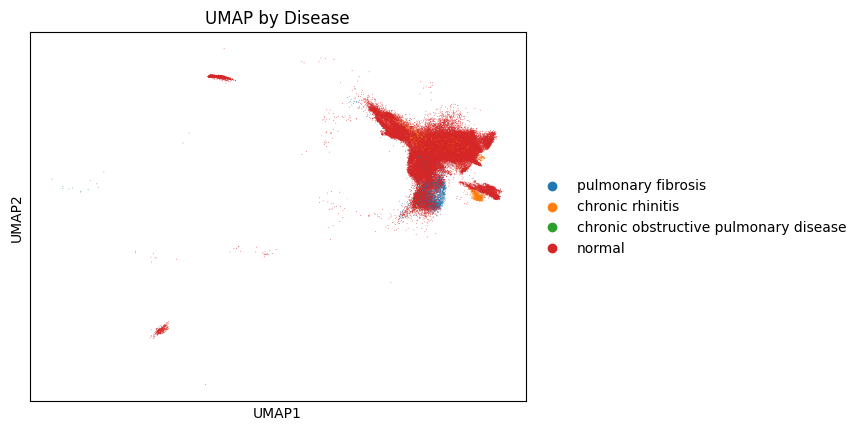

In [103]:
# UMAP by disease
sc.pl.umap(filtered_data, color='disease', title='UMAP by Disease')


ann_level_1 Distribution:
ann_level_1
Epithelial    98731
Name: count, dtype: int64


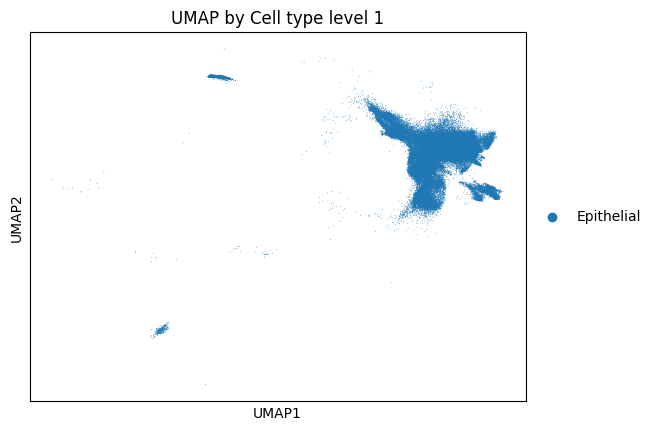


ann_level_2 Distribution:
ann_level_2
Airway epithelium    93962
Submucosal Gland      4769
Name: count, dtype: int64


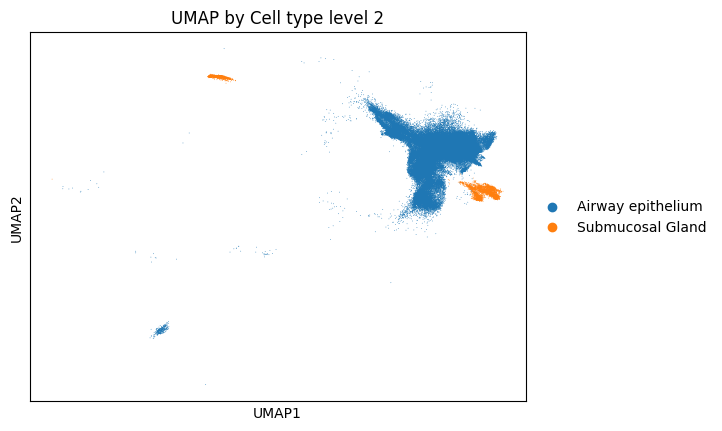


ann_level_3 Distribution:
ann_level_3
Secretory               93962
Submucosal Secretory     4769
Name: count, dtype: int64


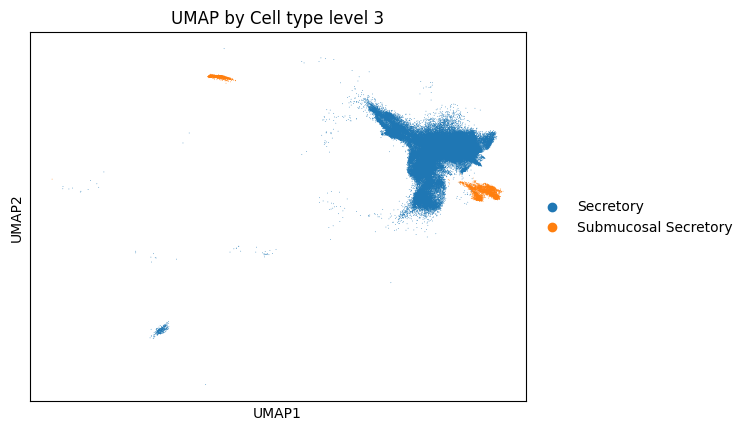


ann_level_4 Distribution:
ann_level_4
Goblet                   70787
Club                     13523
Transitional Club-AT2     9652
SMG serous                4769
Name: count, dtype: int64


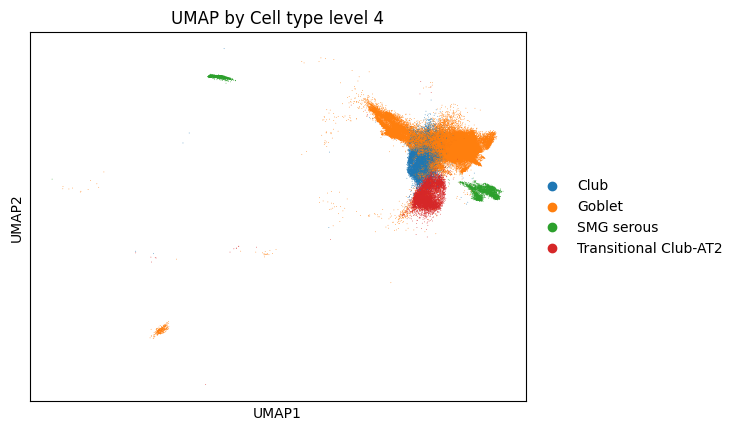


ann_level_5 Distribution:
ann_level_5
Goblet (nasal)            67785
Club (non-nasal)          13523
pre-TB secretory           9652
SMG serous (nasal)         2503
SMG serous (bronchial)     2266
Goblet (bronchial)         1830
Goblet (subsegmental)      1172
Name: count, dtype: int64


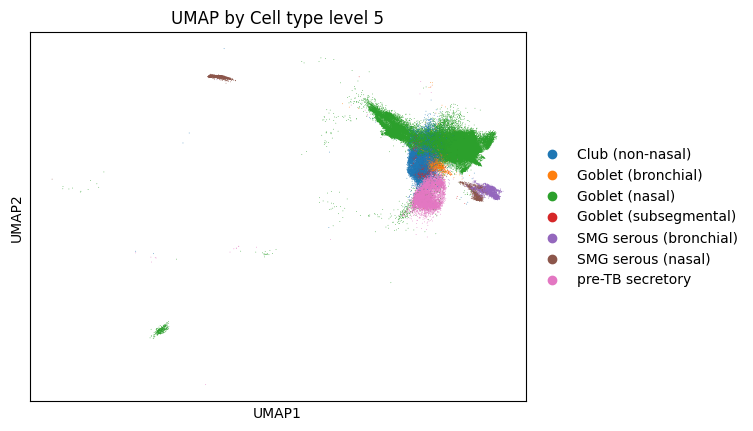

In [112]:
# UMAP by celltype level
for level in ['level_1', 'level_2', 'level_3', 'level_4', 'level_5']:
    column_name = f'ann_level_{level.split("_")[1]}'
    print(f"\n{column_name} Distribution:")
    print(filtered_data.obs[column_name].value_counts())

    sc.pl.umap(filtered_data, color=column_name, title=(f'UMAP by Cell type level {level.split("_")[1]}'))

[None, None, None, None, None, None, None, None]

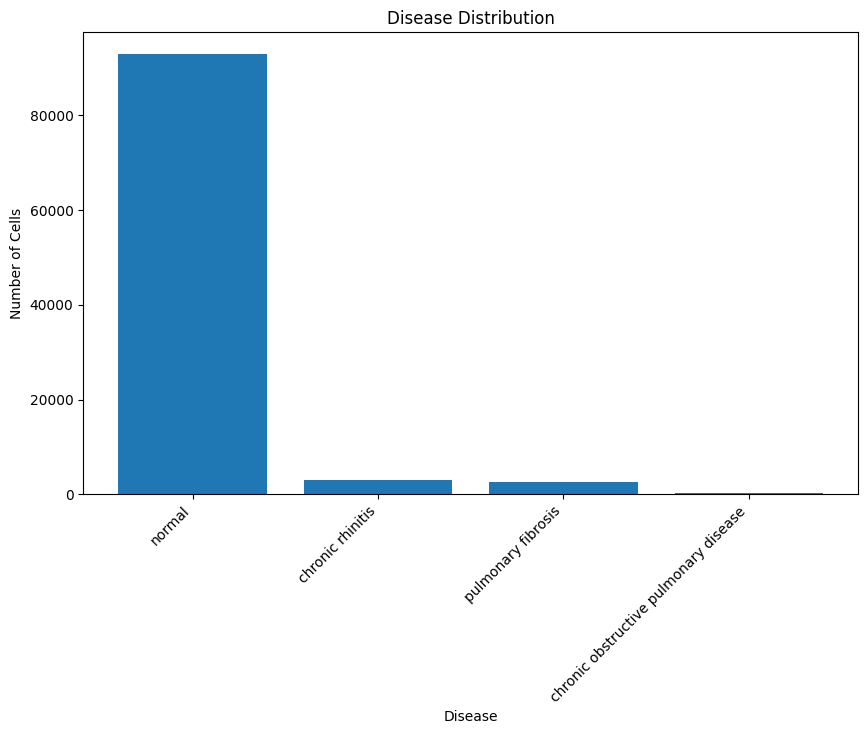

In [122]:
# Set up the plotting
fig, ax1 = plt.subplots(1,  figsize=(10, 6))

# Disease distribution plot
disease_counts = filtered_data.obs['disease'].value_counts()
ax1.bar(disease_counts.index, disease_counts.values)
ax1.set_title('Disease Distribution')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Number of Cells')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')